In [0]:
"""
Use a pretrained VGG16 model to create a fully connected convolutional network
The training is done using the pedestrian dataset.
"""
import os
import cv2
import re
import random
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from glob import glob
from keras.layers import Conv2D, Dense,InputLayer, Conv2DTranspose, Dropout, Activation, Input, Flatten, Add, Deconv2D, MaxPool2D
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model, Sequential
from skimage.transform import resize
from skimage.io import imread
from keras.utils import to_categorical
from keras.utils import plot_model

%matplotlib inline

In [0]:
# Download the dataset
!wget http://www.gavrila.net/data/Daimler/bmvc13-flohr-gavrila/PedCut2013_SegmentationDataset.tar.gz

--2019-03-15 21:12:46--  http://www.gavrila.net/data/Daimler/bmvc13-flohr-gavrila/PedCut2013_SegmentationDataset.tar.gz
Resolving www.gavrila.net (www.gavrila.net)... 134.119.45.88, 2a00:1158:1000:300::558
Connecting to www.gavrila.net (www.gavrila.net)|134.119.45.88|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54546195 (52M) [application/x-tar]
Saving to: ‘PedCut2013_SegmentationDataset.tar.gz’

PedCut2013_Segmenta 100%[===================>]  52.02M  20.4MB/s    in 2.6s    

2019-03-15 21:12:50 (20.4 MB/s) - ‘PedCut2013_SegmentationDataset.tar.gz’ saved [54546195/54546195]



In [0]:
# Extract it
!tar -xzf PedCut2013_SegmentationDataset.tar.gz

In [0]:
# Download VGG to be used as the encoder model
vgg_base_model = VGG16()

Instructions for updating:
Colocations handled automatically by placer.
553467904/553467096 [==============================] - 6s 0us/step


In [0]:
# Load the paths into a dict
data = {}
for root, dirs, files in os.walk('data'):
    if files:
        data[root] =files

for k, v in data.items():
    print("{} -> {} images".format(k, len(v)))

data/validationData/left_images -> 30 images
data/validationData/left_disparity -> 30 images
data/validationData/left_groundTruth -> 30 images
data/completeData/left_images -> 785 images
data/completeData/left_disparity -> 785 images
data/completeData/left_groundTruth -> 785 images
data/testData/left_images -> 300 images
data/testData/left_disparity -> 300 images
data/testData/left_groundTruth -> 300 images


x_img:  (338, 100, 3)
y_img:  (338, 100)


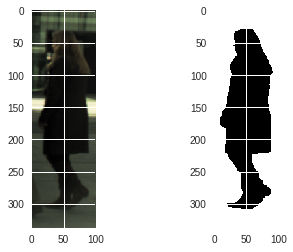

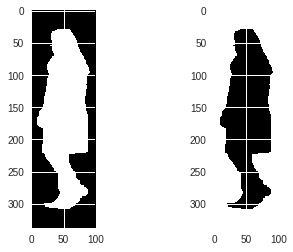

In [0]:
# Show a sample of the input and the segmented images
training_data_x = 'data/completeData/left_images'
training_data_y = 'data/completeData/left_groundTruth'

sample_idx = np.random.randint(0, len(data[training_data_x]))
x_img_path = os.path.join(training_data_x, data[training_data_x][sample_idx])
y_img_path = os.path.join(training_data_y, data[training_data_y][sample_idx])
x_img = imread(x_img_path)
y_img = imread(y_img_path)

print("x_img: ", x_img.shape)
print("y_img: ", y_img.shape)

plt.subplot(121)
plt.imshow(x_img)
plt.subplot(122)
plt.imshow(y_img)
plt.show()

y_img = np.reshape(y_img, (y_img.shape[0], y_img.shape[1], 1))
gt_img = np.concatenate((y_img<0.5, y_img>0.5), axis=2)
plt.subplot(121)
plt.imshow(gt_img[:,:,0])
plt.subplot(122)
plt.imshow(gt_img[:,:,1])
plt.show()

In [0]:
# Freeze VGG model -> Trainable params: 0
for i in range(4):
    vgg_base_model.layers.pop()
for layer in vgg_base_model.layers:
    if layer.name == "block5_conv1":
        break
    layer.trainable=False
vgg_base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

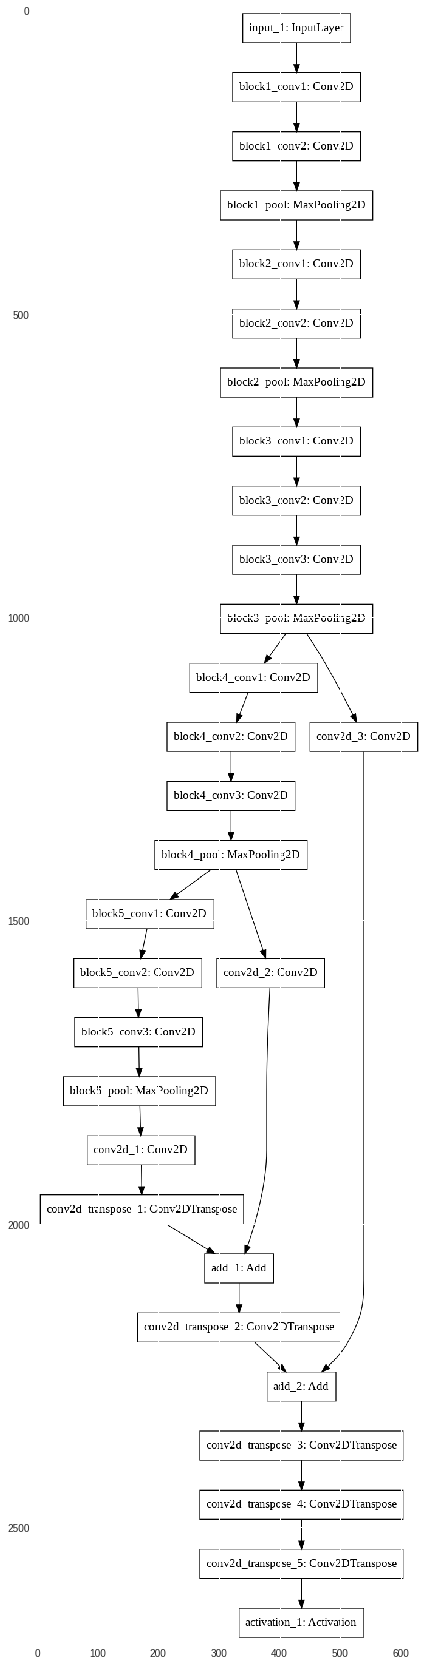

In [0]:
# Create the FCN model
skip1 = vgg_base_model.get_layer('block4_pool').output
skip2 = vgg_base_model.get_layer('block3_pool').output

X = vgg_base_model.get_layer('block5_pool').output
X = Conv2D(2, kernel_size=(1,1), strides=(1,1), padding='same')(X)
X = Conv2DTranspose(2, kernel_size=(4,4), strides=(2,2), padding='same')(X)
skip1 = Conv2D(2,kernel_size=(1,1), strides=(1,1), activation=None)(skip1)
X = Add()([X, skip1])
X = Conv2DTranspose(2, kernel_size=(4,4), strides=(2,2), padding='same')(X)
skip2 = Conv2D(2,kernel_size=(1,1), strides=(1,1), activation=None)(skip2)
X = Add()([X, skip2])
X = Conv2DTranspose(2, kernel_size=(4,4), strides=(2,2),
                   padding='same')(X)
X = Conv2DTranspose(2, kernel_size=(4,4), strides=(2,2),
                   padding='same')(X)
X = Conv2DTranspose(2, kernel_size=(4,4), strides=(2,2),
                   padding='same')(X)
X = Activation('softmax')(X)

# Use the same input dimensions as the vgg base model
model = Model(inputs = vgg_base_model.input, outputs=X, name='fcn8')
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# visualize
plot_model(model, to_file='model.png')
plt.figure(figsize=(30,30))
plt.imshow(plt.imread('model.png'))

In [0]:
# verify the number of trainable parameters in the model
# model.summary()
for layer in model.layers:
    print(layer.name, layer.output.shape, layer.trainable)

input_1 (?, 224, 224, 3) False
block1_conv1 (?, 224, 224, 64) False
block1_conv2 (?, 224, 224, 64) False
block1_pool (?, 112, 112, 64) False
block2_conv1 (?, 112, 112, 128) False
block2_conv2 (?, 112, 112, 128) False
block2_pool (?, 56, 56, 128) False
block3_conv1 (?, 56, 56, 256) False
block3_conv2 (?, 56, 56, 256) False
block3_conv3 (?, 56, 56, 256) False
block3_pool (?, 28, 28, 256) False
block4_conv1 (?, 28, 28, 512) False
block4_conv2 (?, 28, 28, 512) False
block4_conv3 (?, 28, 28, 512) False
block4_pool (?, 14, 14, 512) False
block5_conv1 (?, 14, 14, 512) True
block5_conv2 (?, 14, 14, 512) True
block5_conv3 (?, 14, 14, 512) True
block5_pool (?, 7, 7, 512) True
conv2d_1 (?, 7, 7, 2) True
conv2d_transpose_1 (?, ?, ?, 2) True
conv2d_2 (?, 14, 14, 2) True
add_1 (?, 14, 14, 2) True
conv2d_transpose_2 (?, ?, ?, 2) True
conv2d_3 (?, 28, 28, 2) True
add_2 (?, 28, 28, 2) True
conv2d_transpose_3 (?, ?, ?, 2) True
conv2d_transpose_4 (?, ?, ?, 2) True
conv2d_transpose_5 (?, ?, ?, 2) True
act

In [0]:
x_train_dir = 'data/completeData/left_images'
y_train_dir = 'data/completeData/left_groundTruth'
m = len(data[x_train_dir])
img_height = 224
img_width = 224
n_channels = 3
x_train = np.empty((m, img_height, img_width, n_channels))
y_train = np.empty((m, img_height, img_width,2))

for i in range(m):
    x_img_path = os.path.join(x_train_dir, data[x_train_dir][i])
    x_img = imread(x_img_path)
    x_img = resize(x_img, (img_height, img_width, n_channels))
    x_train[i,:,:,:] = x_img
    y_img_path = os.path.join(y_train_dir, data[y_train_dir][i])
    y_img = imread(y_img_path)
    y_img = resize(y_img, (img_height,img_width))
    y_train[i,:,:,0] = y_img<0.5
    y_train[i,:,:,1] = y_img>0.5
print(x_train.shape, y_train.shape)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(785, 224, 224, 3) (785, 224, 224, 2)


In [0]:
model.fit(x_train, y_train, epochs=30, verbose=1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/30
785/785 [==============================] - 18s 22ms/step - loss: 0.7444 - acc: 0.5139
Epoch 2/30
785/785 [==============================] - 10s 12ms/step - loss: 0.6520 - acc: 0.6130
Epoch 3/30
785/785 [==============================] - 10s 12ms/step - loss: 0.4303 - acc: 0.8103
Epoch 4/30
785/785 [==============================] - 10s 12ms/step - loss: 0.3036 - acc: 0.8718
Epoch 5/30
785/785 [==============================] - 10s 12ms/step - loss: 0.2541 - acc: 0.8924
Epoch 6/30
785/785 [==============================] - 9s 12ms/step - loss: 0.2267 - acc: 0.9039
Epoch 7/30
785/785 [==============================] - 10s 12ms/step - loss: 0.2088 - acc: 0.9112
Epoch 8/30
785/785 [==============================] - 10s 12ms/step - loss: 0.2036 - acc: 0.9136
Epoch 9/30
785/785 [==============================] - 10s 12ms/step - loss: 0.1778 - acc: 0.9244
Ep

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


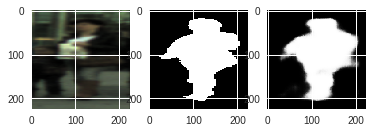

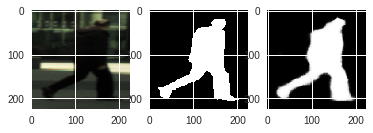

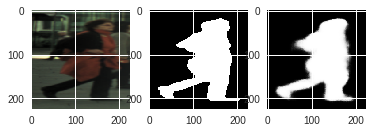

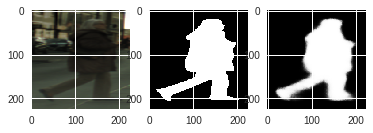

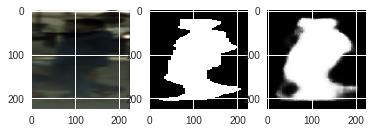

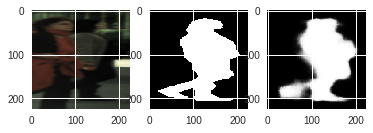

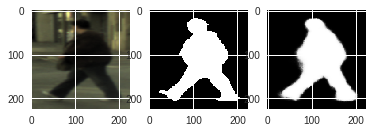

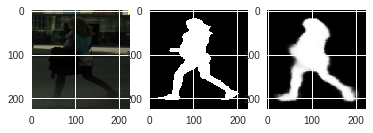

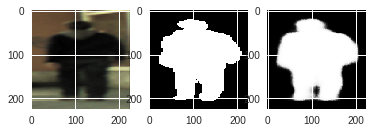

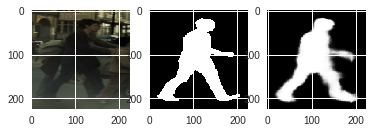

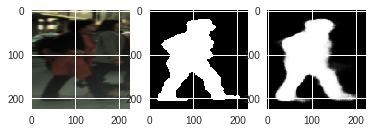

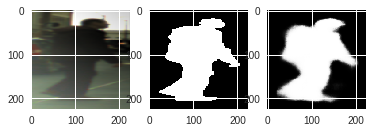

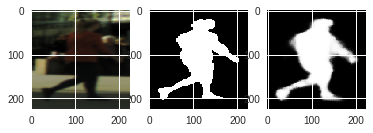

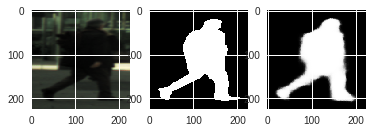

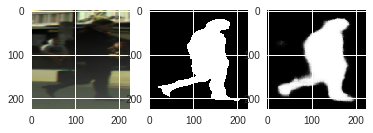

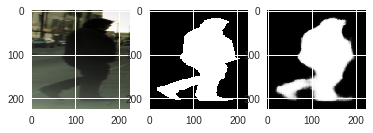

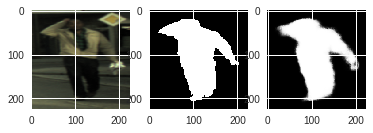

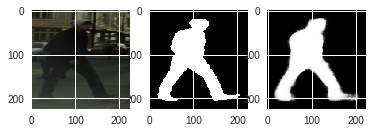

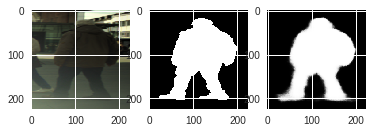

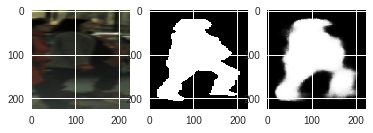

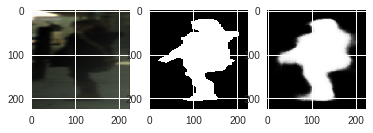

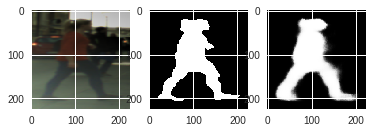

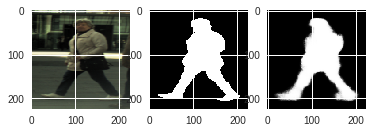

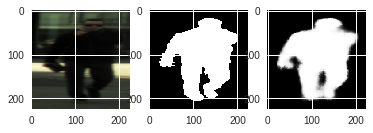

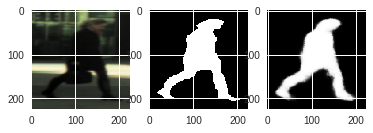

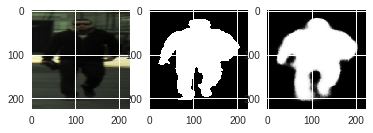

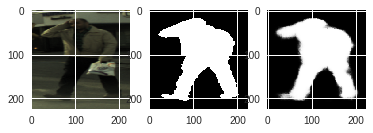

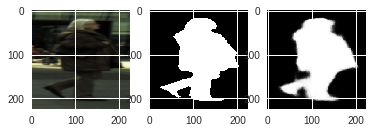

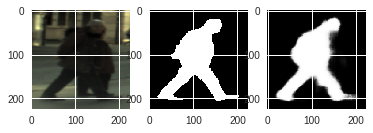

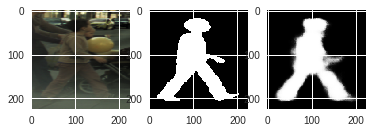

In [18]:
x_valid_dir = 'data/validationData/left_images'
y_valid_dir = 'data/validationData/left_groundTruth'

m = len(data[x_valid_dir])
img_height = 224
img_width = 224
x_valid = np.empty((m, 224, 224, 3))
y_valid = np.empty((m, 224, 224, 2))

for i in range(m):
    x_img_path = os.path.join(x_valid_dir, data[x_valid_dir][i])
    x_img = plt.imread(x_img_path)
    x_img = resize(x_img, (img_height, img_width))
    x_valid[i,:,:,:] = x_img
    y_img_path = os.path.join(y_valid_dir, data[y_valid_dir][i])
    y_img = plt.imread(y_img_path)
    y_img = resize(y_img, (img_height,img_width))
    y_valid[i,:,:,0] = y_img<0.5
    y_valid[i,:,:,1] = y_img>0.5

yhat = model.predict(x_valid)
for i in range(m):
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(x_valid[i])
    plt.subplot(1,3,2)
    plt.imshow(y_valid[i,:,:,0])
    plt.subplot(1,3,3)
    plt.imshow(yhat[i,:,:,0])

(720, 1280, 4)


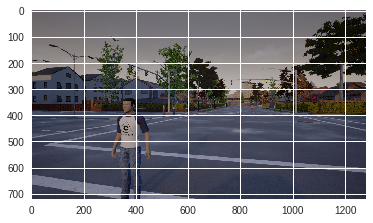

In [192]:
img = plt.imread('../images/carla_sample.png')
print(img.shape)
plt.imshow(img)

(400, 200, 4)


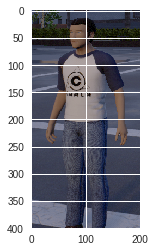

In [159]:
# Cropping the image manually
# TODO: Use region proposals
xs = 320
xe = 720
ys=280
ye = 480
cropped = img[xs:,ys:ye,:]
plt.imshow(cropped)
print(cropped.shape)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(1, 224, 224, 4)


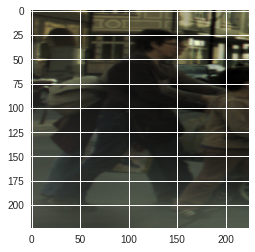

In [191]:
x = resize(cropped, (224,224))
x = x / 255.
x = np.expand_dims(x, axis=0)

print(x.shape)

In [0]:
yhat = model.predict(x[:,:,:,:3])

In [162]:
mask =  yhat[0,:,:,0]>0.5
mask = resize(mask, (400,200))

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


0.91764706
[0.  0.5 0.  0. ]
177.65176


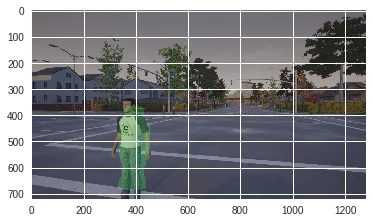

In [206]:
img = plt.imread('00002830.png')
print(img[:,:,1].max(axis=(0,1)))
temp = np.zeros((720,1280,4), dtype=img.dtype)
indices = np.argwhere(mask==False)
temp[indices[:,0]+xs,indices[:,1]+ys,1] = 0.5

dst = cv2.addWeighted(img,0.9,temp,0.4,0)
print(temp.max(axis=(0,1)))            
out += np.asarray(temp)
print(out[:,:,1].max(axis=(0,1)))
plt.imshow(dst)
plt.imsave('foo.png', dst, dpi=300)

In [0]:
model.save("fcn8_pedestrian.h5")